In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,default_data_collator
import torch
from peft import PeftModel
from transformers import GenerationConfig
from transformers.generation.utils import LogitsProcessorList
from transformers.generation.logits_process import LogitsProcessor
from datasets import load_dataset
from torch.utils.data import DataLoader
import os

abs_path = "/data/home/chenpz/git_clone_project"
model_path = f"{abs_path}/All_base_model/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/d3aa29f914761e8ea0298051fbaf8dd173e94db5"
data_path = f"/data/home/chenpz/git_clone_project/nlpData/p3/anli_r3_json_file/anli_r3_train_FFP_all.json"
adpter_path = f"/data/home/chenpz/git_clone_project/LLaMA-Factory/saves/llama3-8b-anli_r3_train_kcg_addHighPPL_first5000_data_gas=5_lr=1e-4/checkpoint-60"
output_file = '../output/anli_r3_loss_trained_By_kcg_addHighPPL_first5000_data_FFP_all.jsonl'

output_dir = os.path.dirname(output_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


device = 'cuda:1'
prompt = \
'''<|begin_of_text|><|start_header_id|>user<|end_header_id|>

{instruction} {input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{output}<|eot_id|>'''



# nf4_config = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_compute_dtype= None
# )


model = AutoModelForCausalLM.from_pretrained(model_path, 
                                             torch_dtype=torch.bfloat16,
                                            #  quantization_config=nf4_config,
                                             device_map = device)

model = PeftModel.from_pretrained(
                    model, adpter_path, is_trainable=False
                    )




/data/home/chenpz/.conda/envs/sft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_path,use_fast=False,split_special_tokens=False,
                                          padding_side="left",
                                          **{'trust_remote_code': True, 'cache_dir': None, 'revision': 'main', 'use_auth_token': None})
tokenizer.pad_token = '<|eot_id|>'

dataset = load_dataset("json", data_files= data_path)

# def preprocess_supervised_data(examples):
#     model_inputs = {'input_ids': [],
#                     'attention_mask':[],
#                     # 'prompt':[]
#                     }
#     for  instruction,input,output in zip(examples['instruction'],examples['input'],examples['output']):
#            text = prompt.format(instruction = instruction, input = input, output = output)
#            res = tokenizer(text,padding='max_length',max_length=1300,truncation=True)
#            model_inputs['input_ids'].append(res['input_ids'])
#            model_inputs['attention_mask'].append(res['attention_mask'])
#           #  model_inputs['prompt'].append(text)
#     return model_inputs


IGNORE_INDEX = -100

question_prompt = '''<|begin_of_text|><|start_header_id|>user<|end_header_id|>

{instruction}{input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''

answer_prompt = '''{output}<|eot_id|>'''

def preprocess_supervised_data(examples) :
        model_inputs = {"input_ids": [], "attention_mask": [], "labels": []}
        max_length = 400
        for  instruction,input,output in zip(examples['instruction'],examples['input'],examples['output']):

            query = question_prompt.format(instruction = instruction, input = input)
            response= answer_prompt.format(output = output)
            
            input_ids, labels = [], []
            source_ids, target_ids = tokenizer([query,response])['input_ids']
            input_ids += source_ids + target_ids
            if len(input_ids) > max_length:
                 print('warning')
            input_ids = input_ids[:max_length]

            labels += [IGNORE_INDEX] * len(source_ids) + target_ids
            labels = labels[:max_length]
            
            model_inputs["input_ids"].append(input_ids)
            model_inputs["attention_mask"].append([1] * len(input_ids))
            model_inputs["labels"].append(labels)

        # Padding: Ensure that all input sequences have the same length
        for i in range(len(model_inputs["input_ids"])):
            padding_length = max_length - len(model_inputs["input_ids"][i])
            
            # Left padding input_ids and attention_mask
            model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * padding_length + model_inputs["input_ids"][i]
            model_inputs["attention_mask"][i] = [0] * padding_length + model_inputs["attention_mask"][i]

            # Left padding labels with IGNORE_INDEX
            model_inputs["labels"][i] = [IGNORE_INDEX] * padding_length + model_inputs["labels"][i]
        
        return model_inputs



dataset2 = dataset.map(preprocess_supervised_data,batched=True,remove_columns=['output', 'input', 'instruction'],num_proc=16)

print(tokenizer.decode(dataset2['train'][0]['input_ids']))

eval_dataloader = DataLoader(dataset2['train'],batch_size=2, pin_memory=True,collate_fn=default_data_collator,shuffle=False)


<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>

In [3]:
from tqdm import tqdm
model.eval()
loss_list =[]
loss_fn = torch.nn.CrossEntropyLoss(
    reduction='none'
    ) # 不要平均，保留每个 token 的 loss
with open(output_file, 'w') as file:  # Open the file in write mode before the loop
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            # outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits

            split_index = (batch['labels'] != -100).int().argmax(dim=-1)

            print(logits.shape)
            shift_logits = logits[..., :-1, :].contiguous()  # 移动 logits 以对齐预测
            shift_labels = batch['labels'][:, 1:].contiguous()  # 移动 labels
            break

            
             # 如果该行全为零，均值为0
            # print(loss_per_sample)
            # for i, loss in enumerate(means):
            #     # print(loss)
            #     # break
            #     sample_id = step * eval_dataloader.batch_size + i  # 用于区分每个样本的索引
            #     add_item = {'id':sample_id,'loss':loss}
            #     file.write('%s\n' % add_item)

  0%|          | 0/50230 [00:00<?, ?it/s]

torch.Size([2, 400, 128256])


In [40]:
tokenizer.decode([220, 128009, 128006])

' <|eot_id|><|start_header_id|>'

In [17]:
mask = (batch['labels'] != -100).int()
mask = mask.unsqueeze(-1) 
result = logits * mask


tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  2.4688,   1.9688,   5.0000,  ...,  -1.4531,  -1.4531,  -1.4531],
        [ -4.2188, -12.1250,  -6.6875,  ...,   5.6562,   5.6562,   5.6562],
        [ -0.1230,   1.1875,   0.6719,  ...,   3.8281,   3.8281,   3.8281]],
       device='cuda:1')

In [39]:
tokenizer.decode([7566, 220, 128009])

' Yes <|eot_id|>'

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 
from scipy.stats import norm

mean_List =[]
std_list = []

for i in range(297, 300):
    # plt.figure()
    data = logits[0,i,:].view(1* 128256).cpu().numpy()
    # data = result = [x for x in data if -8.75 < x < +8.75]
    print(f'{i}: mean:{np.mean(data)} std: {np.std(data)} max:{np.max(data)}')
    # plt.hist(data, bins=5000, density=True, alpha=0.5, label='Histogram')

    # 给定的均值和方差
    mean = np.mean(data)   # 均值
    std_dev = np.std(data) # 标准差

    mean_List.append(mean)
    std_list.append(std_dev)
    # # 生成一个范围用于绘制正态分布密度图
    # x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

    # # 计算正态分布的概率密度函数 (PDF)
    # pdf = norm.pdf(x, mean, std_dev)

    # # 绘制正态分布的密度图
    # plt.plot(x, pdf, label=f'Normal Distribution\nMean = {mean}, Std = {std_dev}')
    # # plt.title('Normal Distribution Density Plot')
    # # plt.xlabel('X')
    # plt.ylabel('Density')
    # # plt.grid(True)
    # # plt.legend()
    # plt.show()


297: mean:-0.8730422854423523 std: 1.8922524452209473 max:28.625
298: mean:0.26609763503074646 std: 1.9123814105987549 max:25.25
299: mean:-0.7236504554748535 std: 1.8615648746490479 max:20.375


In [17]:
batch['labels'][0][297:]

tensor([ 10926,    220, 128009], device='cuda:1')

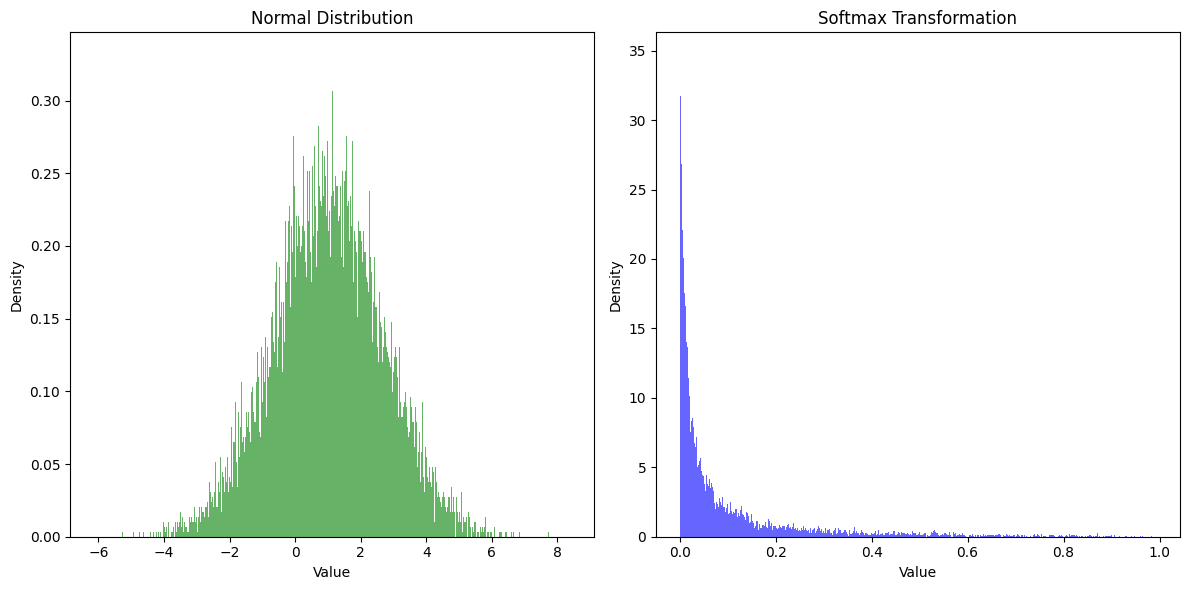

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 生成正态分布数据
mean = 1
std = 1.7
size = 100000
normal_data = np.random.normal(mean, std, size)

# Softmax 函数
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 防止溢出
    return exp_x / np.sum(exp_x)

# 对正态分布数据应用 Softmax
softmax_data = np.array([softmax(normal_data[i:i+10]) for i in range(0, len(normal_data), 10)])

# 绘制正态分布数据与Softmax结果的图形
plt.figure(figsize=(12, 6))

# 原始正态分布
plt.subplot(1, 2, 1)
plt.hist(normal_data, bins=5000, density=True, alpha=0.6, color='g', label='Normal Distribution')
plt.title('Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Softmax后的分布
plt.subplot(1, 2, 2)
plt.hist(softmax_data.flatten(), bins=5000, density=True, alpha=0.6, color='b', label='Softmax Distribution')
plt.title('Softmax Transformation')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()
